## Data Opening and Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

df = pd.read_hdf('/content/drive/MyDrive/audio_lyrics_combined.h5')
df.head()

song_audio song_lyrics Quadrant   AllMusic Id         Artist  \
0       A003        L053       Q3  MT0008469560  Stevie Wonder   
1       A005        L055       Q1  MT0005204984         Prince   
3       A010        L060       Q2  MT0031974477      Pearl Jam   
4       A013        L063       Q2  MT0002578360      The Clash   
6       A023        L073       Q2  MT0002558335     Papa Roach   

            Title                                             Genres  \
0          Lately                      Soul,Pop-Soul,Smooth Soul,R&B   
1  U Got the Look  Dance-Rock,R&B,Contemporary Pop/Rock,Contempor...   
3          Animal  Pop/Rock,Hard Rock,Alternative/Indie Rock,Alte...   
4  London Calling  Pop/Rock,New Wave,British Punk,Punk/New Wave,P...   
6     Last Resort             Alternative Metal,Pop/Rock,Heavy Metal   

                                              lyrics  \
0  Lately I have had the strangest feeling\nWith ...   
1  Here we are folks\nThe dream we all dream off\...   
3  One two three four five against one \nFive fiv...   
4  London calling to the faraway towns\nNow that ...   
6  Cut my life into pieces\nThis is my last resor...   

                                spectrogram_features  
0  [[-80.0, -80.0, -80.0, -80.0, -77.71686, -71.7...  
1  [[-80.0, -80.0, -69.585594, -48.468002, -38.08...  
3  [[-80.0, -79.827644, -59.335518, -55.471622, -...  
4  [[-80.0, -76.85271, -69.828865, -70.31357, -64...  
6  [[-24.160717, -27.344158, -28.813421, -28.3729...

Process Genres Column to make it usable for evaluation (partial labels)

In [3]:
import numpy as np
import pandas as pd

# Define split_genres function
def split_genres(genre_string):
    if isinstance(genre_string, str):
        return [genre.strip() for genre in genre_string.split(',')]
    return []

# Recalculate all_genres_list from the original 'Genres' column
all_genres_list_original = df['Genres'].apply(split_genres).explode()

# Recalculate genre_counts from the original genres
genre_counts = all_genres_list_original.value_counts()

# Now define top_10_genres_list
top_10_genres_list = genre_counts.head(10).index.tolist()

# Recalculate genres_list_of_lists from the original 'Genres' column
genres_list_of_lists = df['Genres'].apply(split_genres).tolist()

def select_top_genre_from_list(genres_for_song_list, top_genres_list):
    """
    Selects the first genre from genres_for_song_list that is present in top_genres_list.
    Returns None if no such genre is found.
    """
    if not isinstance(genres_for_song_list, list):
        return None

    for genre in genres_for_song_list:
        if genre in top_genres_list:
            return genre
    return None

# Apply the function to the genres_list_of_lists
df['Genres'] = [select_top_genre_from_list(genre_list, top_10_genres_list) for genre_list in genres_list_of_lists]

print("DataFrame head with 'Genres' column updated to a single top 10 genre or None:")
display(df.head())
print("\nValue counts of the newly filtered 'Genres' column:")
print(df['Genres'].value_counts(dropna=False))

DataFrame head with 'Genres' column updated to a single top 10 genre or None:


song_audio song_lyrics Quadrant   AllMusic Id         Artist  \
0       A003        L053       Q3  MT0008469560  Stevie Wonder   
1       A005        L055       Q1  MT0005204984         Prince   
3       A010        L060       Q2  MT0031974477      Pearl Jam   
4       A013        L063       Q2  MT0002578360      The Clash   
6       A023        L073       Q2  MT0002558335     Papa Roach   

            Title    Genres  \
0          Lately       R&B   
1  U Got the Look       R&B   
3          Animal  Pop/Rock   
4  London Calling  Pop/Rock   
6     Last Resort  Pop/Rock   

                                              lyrics  \
0  Lately I have had the strangest feeling\nWith ...   
1  Here we are folks\nThe dream we all dream off\...   
3  One two three four five against one \nFive fiv...   
4  London calling to the faraway towns\nNow that ...   
6  Cut my life into pieces\nThis is my last resor...   

                                spectrogram_features  
0  [[-80.0, -80.0, -80.0, -80.0, -77.71686, -71.7...  
1  [[-80.0, -80.0, -69.585594, -48.468002, -38.08...  
3  [[-80.0, -79.827644, -59.335518, -55.471622, -...  
4  [[-80.0, -76.85271, -69.828865, -70.31357, -64...  
6  [[-24.160717, -27.344158, -28.813421, -28.3729...


Value counts of the newly filtered 'Genres' column:
Genres
Pop/Rock         757
Electronic       294
Country          255
Rap              165
Jazz             139
Blues            130
R&B              117
None              95
International     64
Folk              62
Vocal             47
Name: count, dtype: int64


In [4]:
# Remove rows where 'Genres' column is None
df.dropna(subset=['Genres'], inplace=True)

print("\nValue counts of 'Genres' column after removing None:")
print(df['Genres'].value_counts(dropna=False))


Value counts of 'Genres' column after removing None:
Genres
Pop/Rock         757
Electronic       294
Country          255
Rap              165
Jazz             139
Blues            130
R&B              117
International     64
Folk              62
Vocal             47
Name: count, dtype: int64


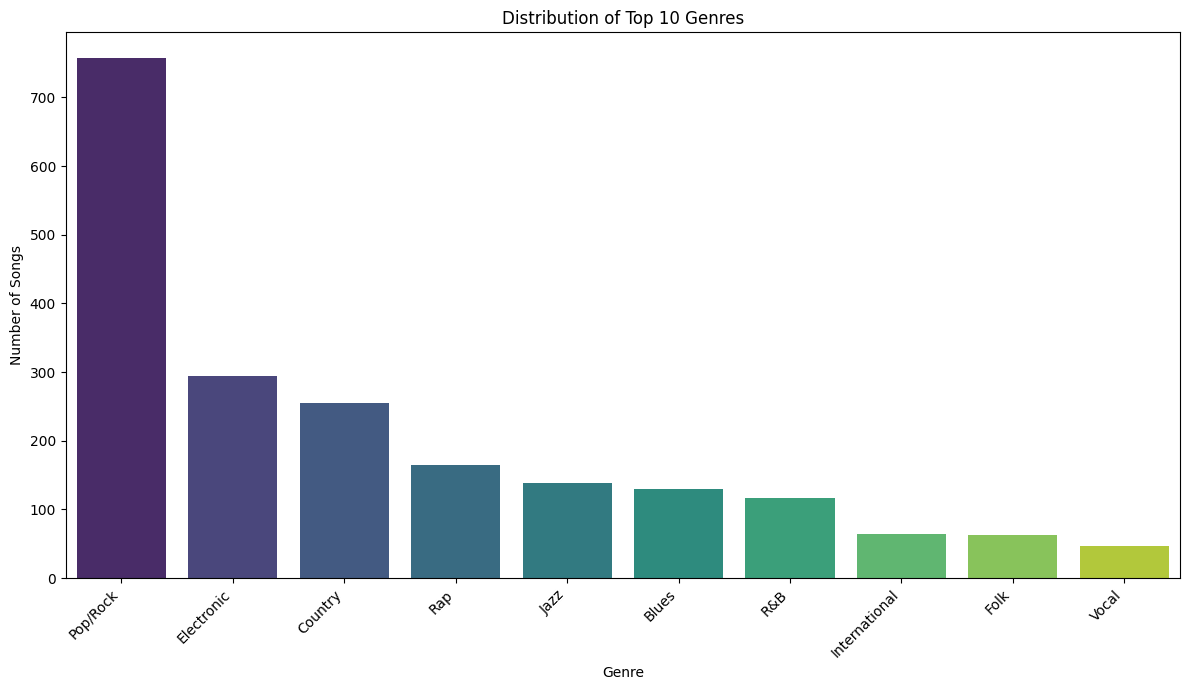

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the value counts of the 'Genres' column
genre_distribution = df['Genres'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette='viridis', hue=genre_distribution.index, legend=False)

plt.title('Distribution of Top 10 Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [6]:
df.shape

(2030, 9)

## Import Required Libraries

In [7]:
# Import all required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.manifold import TSNE

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.9.0+cu126


## Data Preparation

In [8]:
# Prepare spectrogram data
# Initialize an empty list to store processed spectrograms
processed_spectrograms = []
TARGET_TIME = 256  # Define TARGET_TIME for normalization/resizing

for i, spec_raw in enumerate(df['spectrogram_features'].values):
    # Normalize spectrogram (per-sample normalization)
    spec_normalized = (spec_raw - spec_raw.mean()) / (spec_raw.std() + 1e-8)

    # Resize spectrogram to fixed size for CNN (128, TARGET_TIME)
    current_time_dim = spec_normalized.shape[1]

    if current_time_dim > TARGET_TIME:
        # Downsample by taking every nth frame
        step = current_time_dim // TARGET_TIME
        resized_spec = spec_normalized[:, :TARGET_TIME * step:step][:, :TARGET_TIME]
    elif current_time_dim < TARGET_TIME:
        # Pad with zeros if shorter
        padding_needed = TARGET_TIME - current_time_dim
        resized_spec = np.pad(spec_normalized, ((0, 0), (0, padding_needed)), mode='constant')
    else:
        resized_spec = spec_normalized

    processed_spectrograms.append(resized_spec)

# Stack all processed spectrograms into a numpy array
spectrograms_resized = np.stack(processed_spectrograms)

print(f"Resized spectrograms shape: {spectrograms_resized.shape}")

Resized spectrograms shape: (2030, 128, 256)


In [9]:
# Prepare lyrics embeddings using TF-IDF
# Handle missing lyrics
lyrics_data = df['lyrics'].fillna('').values

# Create TF-IDF embeddings
tfidf_vectorizer = TfidfVectorizer(
    max_features=512,  # Limit vocabulary size
    stop_words='english',
    ngram_range=(1, 2),  # Unigrams and bigrams
    min_df=2,
    max_df=0.95
)

lyrics_tfidf = tfidf_vectorizer.fit_transform(lyrics_data).toarray()
print(f"Lyrics TF-IDF shape: {lyrics_tfidf.shape}")

# Normalize lyrics features
lyrics_scaler = StandardScaler()
lyrics_normalized = lyrics_scaler.fit_transform(lyrics_tfidf)
print(f"Lyrics normalized shape: {lyrics_normalized.shape}")

Lyrics TF-IDF shape: (2030, 512)
Lyrics normalized shape: (2030, 512)


In [10]:
# Prepare 'Genres' as labels for evaluation (using partial labels)
genre_label_encoder = LabelEncoder()
encoded_genres = genre_label_encoder.fit_transform(df['Genres'].values)

# Add the encoded genres to the DataFrame
df['encoded_genres'] = encoded_genres

print(f"Classes: {genre_label_encoder.classes_}")
print(f"Label distribution: {np.bincount(encoded_genres)}")
display(df.head())

Classes: ['Blues' 'Country' 'Electronic' 'Folk' 'International' 'Jazz' 'Pop/Rock'
 'R&B' 'Rap' 'Vocal']
Label distribution: [130 255 294  62  64 139 757 117 165  47]


song_audio song_lyrics Quadrant   AllMusic Id         Artist  \
0       A003        L053       Q3  MT0008469560  Stevie Wonder   
1       A005        L055       Q1  MT0005204984         Prince   
3       A010        L060       Q2  MT0031974477      Pearl Jam   
4       A013        L063       Q2  MT0002578360      The Clash   
6       A023        L073       Q2  MT0002558335     Papa Roach   

            Title    Genres  \
0          Lately       R&B   
1  U Got the Look       R&B   
3          Animal  Pop/Rock   
4  London Calling  Pop/Rock   
6     Last Resort  Pop/Rock   

                                              lyrics  \
0  Lately I have had the strangest feeling\nWith ...   
1  Here we are folks\nThe dream we all dream off\...   
3  One two three four five against one \nFive fiv...   
4  London calling to the faraway towns\nNow that ...   
6  Cut my life into pieces\nThis is my last resor...   

                                spectrogram_features  encoded_genres  
0  [[-80.0, -80.0, -80.0, -80.0, -77.71686, -71.7...               7  
1  [[-80.0, -80.0, -69.585594, -48.468002, -38.08...               7  
3  [[-80.0, -79.827644, -59.335518, -55.471622, -...               6  
4  [[-80.0, -76.85271, -69.828865, -70.31357, -64...               6  
6  [[-24.160717, -27.344158, -28.813421, -28.3729...               6

## Building Bimodal Dataset (Audio + Lyrics)

In [11]:
# BIMODAL DATASET PREPARATION (Audio + Lyrics only - no genre as input)

class BimodalMusicDataset(Dataset):
    """Dataset combining audio spectrograms and lyrics embeddings."""

    def __init__(self, spectrograms, lyrics, genre_labels):
        self.spectrograms = torch.FloatTensor(spectrograms).unsqueeze(1)  # Add channel dim
        self.lyrics = torch.FloatTensor(lyrics)
        self.genre_labels = torch.LongTensor(genre_labels)  # For evaluation only

    def __len__(self):
        return len(self.spectrograms)

    def __getitem__(self, idx):
        return {
            'spectrogram': self.spectrograms[idx],
            'lyrics': self.lyrics[idx],
            'genre': self.genre_labels[idx]  # For evaluation
        }

# Create dataset and dataloader
dataset = BimodalMusicDataset(spectrograms_resized, lyrics_normalized, encoded_genres)

# Split into train/val
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"\nDataset size: {len(dataset)}")
print(f"Train size: {train_size}, Val size: {val_size}")
print(f"Spectrogram shape: {dataset.spectrograms.shape}")
print(f"Lyrics shape: {dataset.lyrics.shape}")
print(f"Modalities: Audio (spectrogram) + Lyrics (TF-IDF)")


Dataset size: 2030
Train size: 1725, Val size: 305
Spectrogram shape: torch.Size([2030, 1, 128, 256])
Lyrics shape: torch.Size([2030, 512])
Modalities: Audio (spectrogram) + Lyrics (TF-IDF)


## Define Convolutional VAE (Bimodal: Audio + Lyrics)

In [12]:
# CONVOLUTIONAL VAE MODEL ARCHITECTURE (BIMODAL: Audio + Lyrics)

class AudioEncoder(nn.Module):
    """CNN-based encoder for spectrograms."""

    def __init__(self, latent_dim=64):
        super(AudioEncoder, self).__init__()

        # Convolutional layers for spectrogram encoding
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (128, 256) -> (64, 128)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> (32, 64)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # -> (16, 32)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # -> (8, 16)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # -> (4, 8)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )

        # Calculate flattened size: 512 * 4 * 8 = 16384
        self.flatten_size = 512 * 4 * 8

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_size, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )

        # Output dimension
        self.output_dim = 512

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


class LyricsEncoder(nn.Module):
    """MLP-based encoder for lyrics TF-IDF embeddings."""

    def __init__(self, input_dim=512, hidden_dim=256, output_dim=256):
        super(LyricsEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(hidden_dim, output_dim),
            nn.LeakyReLU(0.2)
        )

        self.output_dim = output_dim

    def forward(self, x):
        return self.encoder(x)


class AudioDecoder(nn.Module):
    """CNN-based decoder for spectrograms."""

    def __init__(self, latent_dim=64):
        super(AudioDecoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 512 * 4 * 8),
            nn.LeakyReLU(0.2)
        )

        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # -> (8, 16)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # -> (16, 32)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> (32, 64)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> (64, 128)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # -> (128, 256)
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 512, 4, 8)
        x = self.deconv_layers(x)
        return x


class LyricsDecoder(nn.Module):
    """MLP-based decoder for lyrics embeddings."""

    def __init__(self, latent_dim=64, hidden_dim=256, output_dim=512):
        super(LyricsDecoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(0.2),

            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, z):
        return self.decoder(z)


class BimodalConvVAE(nn.Module):
    """
    Bimodal Convolutional VAE combining audio spectrograms and lyrics embeddings.
    Uses CNN for audio encoding and MLP for lyrics encoding.
    """

    def __init__(self, lyrics_input_dim=512, latent_dim=64):
        super(BimodalConvVAE, self).__init__()

        self.latent_dim = latent_dim

        # Encoders for both modalities
        self.audio_encoder = AudioEncoder(latent_dim)
        self.lyrics_encoder = LyricsEncoder(input_dim=lyrics_input_dim)

        # Fusion layer (Audio: 512 + Lyrics: 256 = 768)
        fusion_input_dim = self.audio_encoder.output_dim + self.lyrics_encoder.output_dim

        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2)
        )

        # VAE latent space parameters
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoders for both modalities
        self.audio_decoder = AudioDecoder(latent_dim)
        self.lyrics_decoder = LyricsDecoder(latent_dim, output_dim=lyrics_input_dim)

    def encode(self, spectrogram, lyrics):
        audio_feat = self.audio_encoder(spectrogram)
        lyrics_feat = self.lyrics_encoder(lyrics)

        # Concatenate both modality features
        combined = torch.cat([audio_feat, lyrics_feat], dim=1)
        fused = self.fusion(combined)

        mu = self.fc_mu(fused)
        logvar = self.fc_logvar(fused)

        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        audio_recon = self.audio_decoder(z)
        lyrics_recon = self.lyrics_decoder(z)
        return audio_recon, lyrics_recon

    def forward(self, spectrogram, lyrics):
        mu, logvar = self.encode(spectrogram, lyrics)
        z = self.reparameterize(mu, logvar)
        audio_recon, lyrics_recon = self.decode(z)
        return audio_recon, lyrics_recon, mu, logvar, z

    def get_latent(self, spectrogram, lyrics):
        """Get latent representation without reparameterization (for inference)."""
        mu, logvar = self.encode(spectrogram, lyrics)
        return mu


# Initialize model
LATENT_DIM = 64
LYRICS_DIM = lyrics_normalized.shape[1]

model = BimodalConvVAE(
    lyrics_input_dim=LYRICS_DIM,
    latent_dim=LATENT_DIM
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nModalities: Audio (spectrogram) + Lyrics (TF-IDF)")
print(f"Latent dimension: {LATENT_DIM}")
print(f"\nModel architecture:\n{model}")

Total parameters: 22,222,561
Trainable parameters: 22,222,561

Modalities: Audio (spectrogram) + Lyrics (TF-IDF)
Latent dimension: 64

Model architecture:
BimodalConvVAE(
  (audio_encoder): AudioEncoder(
    (conv_layers): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2)
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

## Define Loss Function and Training Setup

In [13]:
# LOSS FUNCTIONS AND TRAINING (BIMODAL)

def bimodal_vae_loss(audio_recon, audio_orig, lyrics_recon, lyrics_orig, mu, logvar):
    """
    Bimodal VAE loss combining:
    - Audio reconstruction loss (MSE)
    - Lyrics reconstruction loss (MSE)
    - KL divergence
    """
    # Audio reconstruction loss (MSE)
    audio_recon_loss = F.mse_loss(audio_recon, audio_orig, reduction='sum')

    # Lyrics reconstruction loss (MSE)
    lyrics_recon_loss = F.mse_loss(lyrics_recon, lyrics_orig, reduction='sum')

    # Total reconstruction loss
    recon_loss = audio_recon_loss + lyrics_recon_loss

    # KL Divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total VAE loss
    total_loss = recon_loss + kl_divergence

    return total_loss, recon_loss, kl_divergence, audio_recon_loss, lyrics_recon_loss


def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for batch in train_loader:
        spectrogram = batch['spectrogram'].to(device)
        lyrics = batch['lyrics'].to(device)

        optimizer.zero_grad()

        audio_recon, lyrics_recon, mu, logvar, z = model(spectrogram, lyrics)

        loss, recon, kl, audio_loss, lyrics_loss = bimodal_vae_loss(
            audio_recon, spectrogram,
            lyrics_recon, lyrics,
            mu, logvar
        )

        loss = loss / spectrogram.size(0)  # Normalize by batch size
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item() / spectrogram.size(0)
        total_kl += kl.item() / spectrogram.size(0)

    n_batches = len(train_loader)
    return total_loss / n_batches, total_recon / n_batches, total_kl / n_batches


def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    with torch.no_grad():
        for batch in val_loader:
            spectrogram = batch['spectrogram'].to(device)
            lyrics = batch['lyrics'].to(device)

            audio_recon, lyrics_recon, mu, logvar, z = model(spectrogram, lyrics)

            loss, recon, kl, _, _ = bimodal_vae_loss(
                audio_recon, spectrogram,
                lyrics_recon, lyrics,
                mu, logvar
            )

            loss = loss / spectrogram.size(0)

            total_loss += loss.item()
            total_recon += recon.item() / spectrogram.size(0)
            total_kl += kl.item() / spectrogram.size(0)

    n_batches = len(val_loader)
    return total_loss / n_batches, total_recon / n_batches, total_kl / n_batches


print("Bimodal loss functions and training utilities defined.")
print("Loss = Audio_MSE + Lyrics_MSE + KL_Divergence")

Bimodal loss functions and training utilities defined.
Loss = Audio_MSE + Lyrics_MSE + KL_Divergence


## Training

In [14]:
# TRAIN BIMODAL CONVOLUTIONAL VAE MODEL

# Training configuration
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Training history
history = {
    'train_loss': [], 'train_recon': [], 'train_kl': [],
    'val_loss': [], 'val_recon': [], 'val_kl': []
}

best_val_loss = float('inf')
best_model_state = None

print(f"Training Bimodal Convolutional VAE with latent_dim={LATENT_DIM}")
print(f"Modalities: Audio + Lyrics")
print(f"Epochs: {NUM_EPOCHS}, LR: {LEARNING_RATE}")
print("-" * 60)

for epoch in tqdm(range(NUM_EPOCHS), desc="Training"):
    # Train
    train_loss, train_recon, train_kl = train_epoch(model, train_loader, optimizer, device)

    # Validate
    val_loss, val_recon, val_kl = validate(model, val_loader, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_recon'].append(train_recon)
    history['train_kl'].append(train_kl)
    history['val_loss'].append(val_loss)
    history['val_recon'].append(val_recon)
    history['val_kl'].append(val_kl)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
        print(f"  Train - Loss: {train_loss:.4f}, Recon: {train_recon:.4f}, KL: {train_kl:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Recon: {val_recon:.4f}, KL: {val_kl:.4f}")


# Load best model
model.load_state_dict(best_model_state)
print(f"\nTraining complete! Best validation loss: {best_val_loss:.4f}")

Training Bimodal Convolutional VAE with latent_dim=64
Modalities: Audio + Lyrics
Epochs: 20, LR: 0.0001
------------------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/20
  Train - Loss: 14992.3748, Recon: 14921.0360, KL: 71.3388
  Val   - Loss: 14688.0222, Recon: 14619.1603, KL: 68.8620
Epoch 20/20
  Train - Loss: 14589.7052, Recon: 14496.3754, KL: 93.3298
  Val   - Loss: 14385.7256, Recon: 14298.4357, KL: 87.2900

Training complete! Best validation loss: 14382.4175


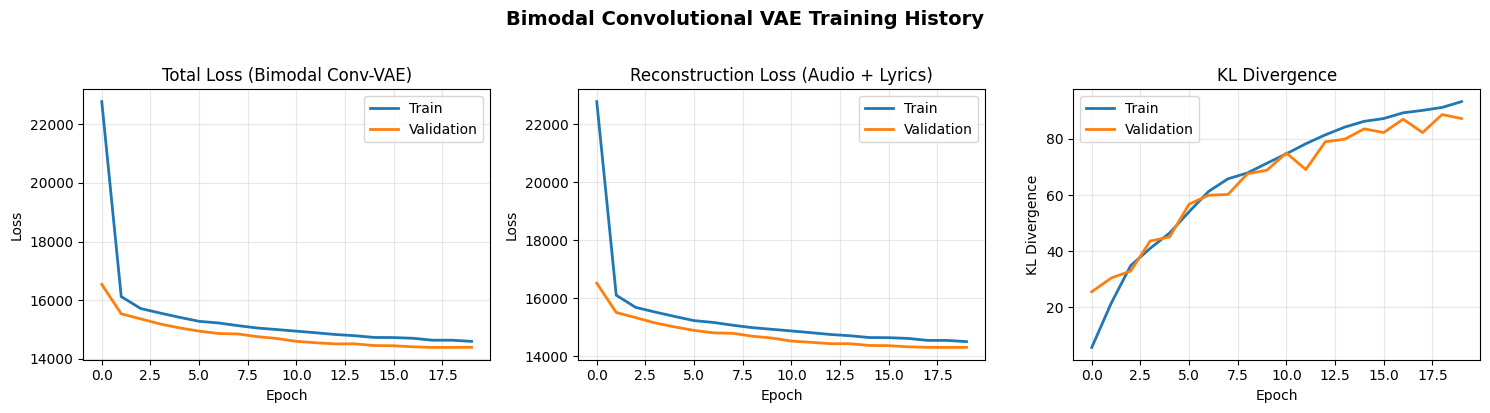

In [15]:
# PLOT TRAINING HISTORY

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Total Loss
axes[0].plot(history['train_loss'], label='Train', linewidth=2)
axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total Loss (Bimodal Conv-VAE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Reconstruction Loss
axes[1].plot(history['train_recon'], label='Train', linewidth=2)
axes[1].plot(history['val_recon'], label='Validation', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Reconstruction Loss (Audio + Lyrics)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# KL Divergence
axes[2].plot(history['train_kl'], label='Train', linewidth=2)
axes[2].plot(history['val_kl'], label='Validation', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('KL Divergence')
axes[2].set_title('KL Divergence')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.suptitle('Bimodal Convolutional VAE Training History', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Extract Latent Representations

In [16]:
# EXTRACT LATENT REPRESENTATIONS

def extract_all_latents(model, dataset, device, batch_size=64):
    """Extract latent representations for the entire dataset."""
    model.eval()

    # Create a dataloader for the full dataset
    full_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_latents = []
    all_genres = []

    with torch.no_grad():
        for batch in tqdm(full_loader, desc="Extracting latents"):
            spectrogram = batch['spectrogram'].to(device)
            lyrics = batch['lyrics'].to(device)
            genres = batch['genre']

            # Get latent representations (mean of the distribution)
            latent = model.get_latent(spectrogram, lyrics)

            all_latents.append(latent.cpu().numpy())
            all_genres.append(genres.numpy())

    latents = np.vstack(all_latents)
    genres = np.concatenate(all_genres)

    return latents, genres

# Extract latents for the full dataset
latent_representations, genre_labels = extract_all_latents(model, dataset, device)
print(f"Latent representations shape: {latent_representations.shape}")
print(f"Genre labels shape: {genre_labels.shape}")
print(f"\nLatent space now encodes information from both modalities: Audio + Lyrics")

Extracting latents:   0%|          | 0/32 [00:00<?, ?it/s]

Latent representations shape: (2030, 64)
Genre labels shape: (2030,)

Latent space now encodes information from both modalities: Audio + Lyrics


## Clustering Evaluation Metrics

In [17]:
# CLUSTERING EVALUATION METRICS

def evaluate_clustering(latents, true_labels, cluster_labels, method_name=""):
    """
    Comprehensive clustering evaluation using:
    - Silhouette Score
    - Davies-Bouldin Index
    - Adjusted Rand Index (ARI) - using partial labels
    """
    results = {}

    # Silhouette Score (higher is better, range: -1 to 1)
    if len(np.unique(cluster_labels)) > 1:
        results['silhouette'] = silhouette_score(latents, cluster_labels)
    else:
        results['silhouette'] = -1

    # Davies-Bouldin Index (lower is better)
    if len(np.unique(cluster_labels)) > 1:
        results['davies_bouldin'] = davies_bouldin_score(latents, cluster_labels)
    else:
        results['davies_bouldin'] = float('inf')

    # Adjusted Rand Index (using partial labels, range: -1 to 1, higher is better)
    results['ari'] = adjusted_rand_score(true_labels, cluster_labels)

    print(f"\n{'='*50}")
    print(f"Clustering Results: {method_name}")
    print(f"{'='*50}")
    print(f"Silhouette Score:      {results['silhouette']:.4f} (higher is better)")
    print(f"Davies-Bouldin Index:  {results['davies_bouldin']:.4f} (lower is better)")
    print(f"Adjusted Rand Index:   {results['ari']:.4f} (higher is better)")

    return results


print("Clustering evaluation metrics defined.")

Clustering evaluation metrics defined.


## Clustering with K-Means, Agglomerative Clustering, and DBSCAN

In [18]:
# CLUSTERING ON VAE LATENT SPACE

n_clusters = len(genre_label_encoder.classes_)
print(f"Number of clusters (based on genres): {n_clusters}")

# Store all clustering results
vae_clustering_results = {}

# 1. K-Means Clustering
print("\n" + "="*60)
print("1. K-MEANS CLUSTERING ON VAE LATENT SPACE")
print("="*60)
kmeans_vae = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
kmeans_labels = kmeans_vae.fit_predict(latent_representations)
vae_clustering_results['K-Means'] = evaluate_clustering(
    latent_representations, genre_labels, kmeans_labels, "Conv-VAE + K-Means"
)

# 2. Agglomerative Clustering
print("\n" + "="*60)
print("2. AGGLOMERATIVE CLUSTERING ON VAE LATENT SPACE")
print("="*60)
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
agg_labels = agg_clustering.fit_predict(latent_representations)
vae_clustering_results['Agglomerative'] = evaluate_clustering(
    latent_representations, genre_labels, agg_labels, "Conv-VAE + Agglomerative"
)

# 3. DBSCAN Clustering
print("\n" + "="*60)
print("3. DBSCAN CLUSTERING ON VAE LATENT SPACE")
print("="*60)
# DBSCAN requires tuning eps and min_samples
# Use StandardScaler on latents for better DBSCAN performance
latents_scaled = StandardScaler().fit_transform(latent_representations)

# Use k-nearest neighbors to find optimal eps
# This is the recommended approach for DBSCAN parameter selection
from sklearn.neighbors import NearestNeighbors

min_samples = 5  # Rule of thumb: 2 * dimensions, but we use a smaller value
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(latents_scaled)
distances, _ = nn.kneighbors(latents_scaled)

# Get the distance to the k-th nearest neighbor for each point
k_distances = np.sort(distances[:, min_samples-1])

# Use the "elbow" point as eps - typically around 90th percentile works well
# Or use the mean + std of distances
eps_candidates = [
    np.percentile(k_distances, 50),  # median
    np.percentile(k_distances, 75),  # 75th percentile
    np.percentile(k_distances, 90),  # 90th percentile
    np.mean(k_distances),            # mean
    np.mean(k_distances) + np.std(k_distances)  # mean + std
]

print(f"k-distance statistics (k={min_samples}):")
print(f"  Min: {k_distances.min():.4f}, Max: {k_distances.max():.4f}")
print(f"  Mean: {np.mean(k_distances):.4f}, Std: {np.std(k_distances):.4f}")
print(f"  Percentiles - 50th: {np.percentile(k_distances, 50):.4f}, 75th: {np.percentile(k_distances, 75):.4f}, 90th: {np.percentile(k_distances, 90):.4f}")

# Try different eps values based on data distribution
best_dbscan_score = -2
best_eps = np.percentile(k_distances, 90)  # Default to 90th percentile
best_min_samples = min_samples
best_n_clusters = 0

for eps in eps_candidates:
    for ms in [3, 5, 10]:
        dbscan = DBSCAN(eps=eps, min_samples=ms)
        labels = dbscan.fit_predict(latents_scaled)
        n_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_ratio = n_noise / len(labels)

        # Only consider if we have at least 2 clusters and less than 50% noise
        if n_clusters_found >= 2 and noise_ratio < 0.5:
            # Filter out noise for silhouette calculation
            mask = labels != -1
            if mask.sum() > n_clusters_found:
                score = silhouette_score(latents_scaled[mask], labels[mask])
                if score > best_dbscan_score:
                    best_dbscan_score = score
                    best_eps = eps
                    best_min_samples = ms
                    best_n_clusters = n_clusters_found

# If no good clustering found, use a fallback approach
if best_n_clusters < 2:
    print("\nNo optimal DBSCAN parameters found with standard approach.")
    print("Using adaptive eps based on 95th percentile of k-distances...")
    best_eps = np.percentile(k_distances, 95)
    best_min_samples = 3

print(f"\nBest DBSCAN parameters: eps={best_eps:.4f}, min_samples={best_min_samples}")
dbscan_final = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan_final.fit_predict(latents_scaled)

# Count noise points and clusters
n_noise = list(dbscan_labels).count(-1)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"DBSCAN found {n_clusters_dbscan} clusters and {n_noise} noise points ({100*n_noise/len(dbscan_labels):.1f}% noise)")

vae_clustering_results['DBSCAN'] = evaluate_clustering(
    latents_scaled, genre_labels, dbscan_labels, "Conv-VAE + DBSCAN"
)

Number of clusters (based on genres): 10

1. K-MEANS CLUSTERING ON VAE LATENT SPACE

Clustering Results: Conv-VAE + K-Means
Silhouette Score:      0.0868 (higher is better)
Davies-Bouldin Index:  2.1155 (lower is better)
Adjusted Rand Index:   0.0254 (higher is better)

2. AGGLOMERATIVE CLUSTERING ON VAE LATENT SPACE

Clustering Results: Conv-VAE + Agglomerative
Silhouette Score:      0.0389 (higher is better)
Davies-Bouldin Index:  2.6113 (lower is better)
Adjusted Rand Index:   0.0129 (higher is better)

3. DBSCAN CLUSTERING ON VAE LATENT SPACE
k-distance statistics (k=5):
  Min: 2.3724, Max: 17.0120
  Mean: 5.2952, Std: 1.5001
  Percentiles - 50th: 5.0581, 75th: 6.0751, 90th: 7.1748

Best DBSCAN parameters: eps=6.0751, min_samples=3
DBSCAN found 2 clusters and 275 noise points (13.5% noise)

Clustering Results: Conv-VAE + DBSCAN
Silhouette Score:      0.1617 (higher is better)
Davies-Bouldin Index:  4.4906 (lower is better)
Adjusted Rand Index:   0.0093 (higher is better)


## Baseline: PCA + K-Means

In [19]:
# BASELINE: PCA + K-MEANS

print("="*60)
print("BASELINE: PCA + K-MEANS")
print("="*60)

# Combine audio and lyrics features for baseline
spectrograms_flat = spectrograms_resized.reshape(spectrograms_resized.shape[0], -1)
combined_features = np.hstack([spectrograms_flat, lyrics_normalized])
print(f"Combined features shape: {combined_features.shape}")

# Standardize features
scaler_baseline = StandardScaler()
combined_scaled = scaler_baseline.fit_transform(combined_features)

# Apply PCA (reduce to same dimension as latent space for fair comparison)
pca = PCA(n_components=LATENT_DIM, random_state=42)
pca_features = pca.fit_transform(combined_scaled)
print(f"PCA features shape: {pca_features.shape}")
print(f"PCA explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")

# Store baseline results
baseline_results = {}

# K-Means on PCA features
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
pca_kmeans_labels = kmeans_pca.fit_predict(pca_features)
baseline_results['PCA + K-Means'] = evaluate_clustering(
    pca_features, genre_labels, pca_kmeans_labels, "PCA + K-Means (Baseline)"
)

# Also apply Agglomerative and DBSCAN to PCA for comparison
print("\n" + "="*60)
print("BASELINE: PCA + AGGLOMERATIVE")
print("="*60)
agg_pca = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
pca_agg_labels = agg_pca.fit_predict(pca_features)
baseline_results['PCA + Agglomerative'] = evaluate_clustering(
    pca_features, genre_labels, pca_agg_labels, "PCA + Agglomerative (Baseline)"
)

print("\n" + "="*60)
print("BASELINE: PCA + DBSCAN")
print("="*60)
pca_scaled = StandardScaler().fit_transform(pca_features)
dbscan_pca = DBSCAN(eps=best_eps, min_samples=best_min_samples)
pca_dbscan_labels = dbscan_pca.fit_predict(pca_scaled)
n_clusters_pca_dbscan = len(set(pca_dbscan_labels)) - (1 if -1 in pca_dbscan_labels else 0)
print(f"DBSCAN on PCA found {n_clusters_pca_dbscan} clusters")
baseline_results['PCA + DBSCAN'] = evaluate_clustering(
    pca_scaled, genre_labels, pca_dbscan_labels, "PCA + DBSCAN (Baseline)"
)

BASELINE: PCA + K-MEANS
Combined features shape: (2030, 33280)
PCA features shape: (2030, 64)
PCA explained variance ratio: 0.3813

Clustering Results: PCA + K-Means (Baseline)
Silhouette Score:      0.0654 (higher is better)
Davies-Bouldin Index:  2.9038 (lower is better)
Adjusted Rand Index:   0.0366 (higher is better)

BASELINE: PCA + AGGLOMERATIVE

Clustering Results: PCA + Agglomerative (Baseline)
Silhouette Score:      0.0375 (higher is better)
Davies-Bouldin Index:  3.1131 (lower is better)
Adjusted Rand Index:   0.0343 (higher is better)

BASELINE: PCA + DBSCAN
DBSCAN on PCA found 1 clusters

Clustering Results: PCA + DBSCAN (Baseline)
Silhouette Score:      -0.0460 (higher is better)
Davies-Bouldin Index:  9.1281 (lower is better)
Adjusted Rand Index:   -0.0183 (higher is better)


## Comparison Summary Table

In [20]:
# COMPARISON SUMMARY TABLE

# Compile all results
all_results = {**vae_clustering_results, **baseline_results}

comparison_data = {
    'Method': [],
    'Silhouette': [],
    'Davies-Bouldin': [],
    'ARI': []
}

for method, results in all_results.items():
    comparison_data['Method'].append(method)
    comparison_data['Silhouette'].append(results['silhouette'])
    comparison_data['Davies-Bouldin'].append(results['davies_bouldin'])
    comparison_data['ARI'].append(results['ari'])

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

# Sort by Silhouette Score (descending)
comparison_df = comparison_df.sort_values('Silhouette', ascending=False)

print("\n" + "="*70)
print("CLUSTERING METHODS COMPARISON")
print("="*70)
display(comparison_df)

# Highlight best results
print("\n📊 Best Results:")
print(f"  Best Silhouette Score: {comparison_df.iloc[0]['Method']} ({comparison_df.iloc[0]['Silhouette']:.4f})")
best_db_idx = comparison_df['Davies-Bouldin'].idxmin()
print(f"  Best Davies-Bouldin:   {comparison_df.loc[best_db_idx]['Method']} ({comparison_df.loc[best_db_idx]['Davies-Bouldin']:.4f})")
best_ari_idx = comparison_df['ARI'].idxmax()
print(f"  Best ARI:              {comparison_df.loc[best_ari_idx]['Method']} ({comparison_df.loc[best_ari_idx]['ARI']:.4f})")


CLUSTERING METHODS COMPARISON


Method  Silhouette  Davies-Bouldin     ARI
2               DBSCAN      0.1617          4.4906  0.0093
0              K-Means      0.0868          2.1155  0.0254
3        PCA + K-Means      0.0654          2.9038  0.0366
1        Agglomerative      0.0389          2.6113  0.0129
4  PCA + Agglomerative      0.0375          3.1131  0.0343
5         PCA + DBSCAN     -0.0460          9.1281 -0.0183


📊 Best Results:
  Best Silhouette Score: DBSCAN (0.1617)
  Best Davies-Bouldin:   K-Means (2.1155)
  Best ARI:              PCA + K-Means (0.0366)


## Visualization: Comparison Bar Charts

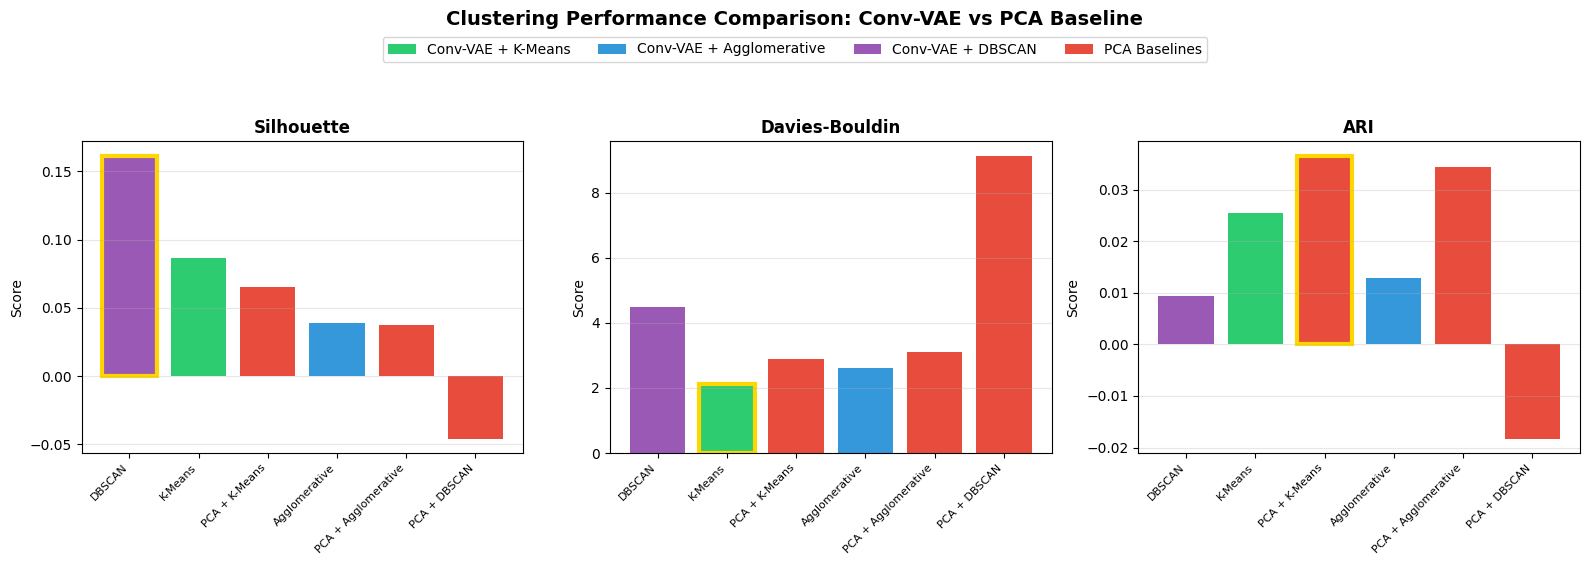

In [21]:
# VISUALIZATION: COMPARISON BAR CHART

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
metrics = ['Silhouette', 'Davies-Bouldin', 'ARI']

# Define colors for VAE vs Baseline
method_names = comparison_df['Method'].tolist()
colors = ['#2ecc71' if 'K-Means' in m and 'PCA' not in m else
          '#3498db' if 'Agglomerative' in m and 'PCA' not in m else
          '#9b59b6' if 'DBSCAN' in m and 'PCA' not in m else
          '#e74c3c' for m in method_names]

for i, metric in enumerate(metrics):
    values = comparison_df[metric].values
    bars = axes[i].bar(range(len(comparison_df)), values, color=colors)
    axes[i].set_xticks(range(len(comparison_df)))
    axes[i].set_xticklabels(method_names, rotation=45, ha='right', fontsize=8)
    axes[i].set_title(metric, fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Score')
    axes[i].grid(True, alpha=0.3, axis='y')

    # Highlight best
    if metric == 'Davies-Bouldin':
        best_idx = np.argmin(values)
    else:
        best_idx = np.argmax(values)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', label='Conv-VAE + K-Means'),
    Patch(facecolor='#3498db', label='Conv-VAE + Agglomerative'),
    Patch(facecolor='#9b59b6', label='Conv-VAE + DBSCAN'),
    Patch(facecolor='#e74c3c', label='PCA Baselines')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.08))

plt.suptitle('Clustering Performance Comparison: Conv-VAE vs PCA Baseline', fontsize=14, fontweight='bold', y=1.12)
plt.tight_layout()
plt.show()

## Visualization: t-SNE Latent Space

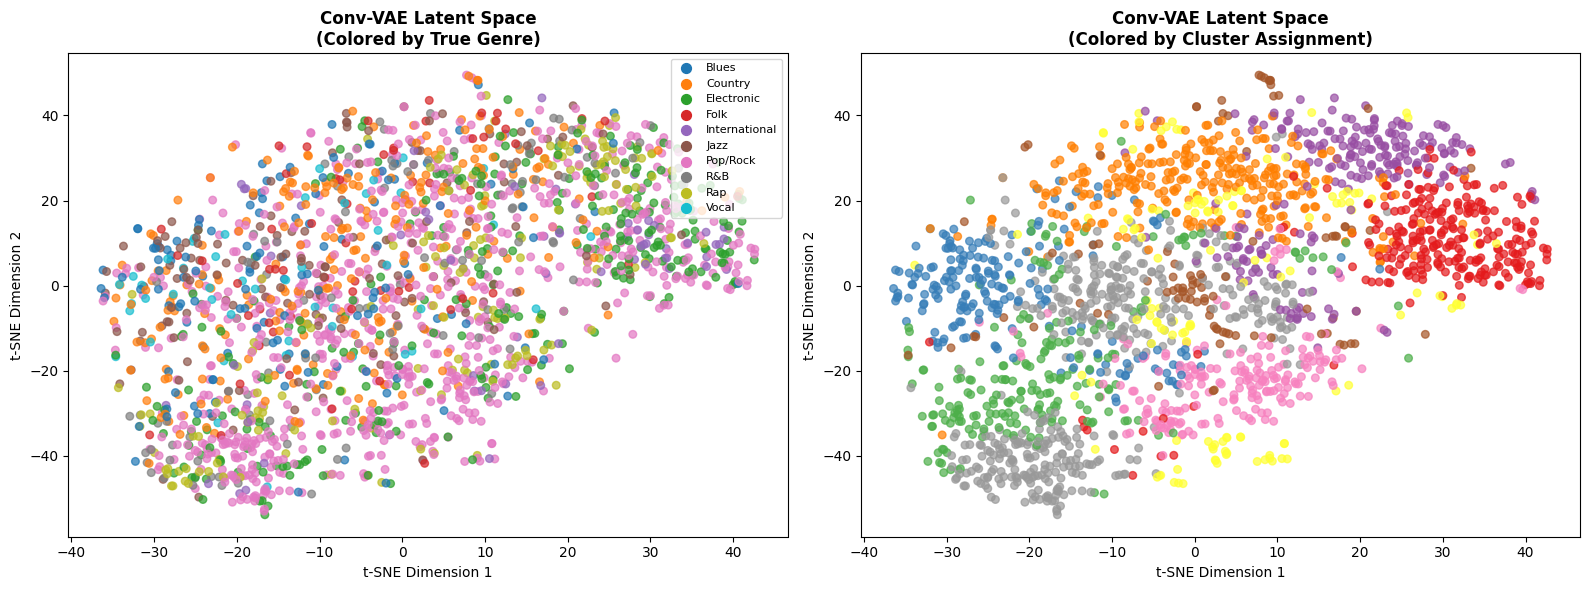

In [22]:
# VISUALIZATION: LATENT SPACE (t-SNE)

genre_names = genre_label_encoder.classes_

def plot_latent_space_tsne(latents, labels, label_names, title, cluster_labels=None):
    """Visualize latent space using t-SNE."""

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(latents)-1))
    latents_2d = tsne.fit_transform(latents)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Colored by true genre labels
    scatter1 = axes[0].scatter(
        latents_2d[:, 0], latents_2d[:, 1],
        c=labels, cmap='tab10', alpha=0.7, s=30
    )
    axes[0].set_title(f'{title}\n(Colored by True Genre)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('t-SNE Dimension 1')
    axes[0].set_ylabel('t-SNE Dimension 2')

    # Add legend
    unique_labels = np.unique(labels)
    handles = [plt.scatter([], [], c=plt.cm.tab10(l / len(unique_labels)), s=50, label=label_names[l])
               for l in unique_labels]
    axes[0].legend(handles=handles, labels=[label_names[l] for l in unique_labels],
                   loc='upper right', fontsize=8, markerscale=1)

    # Plot 2: Colored by cluster assignments
    if cluster_labels is not None:
        scatter2 = axes[1].scatter(
            latents_2d[:, 0], latents_2d[:, 1],
            c=cluster_labels, cmap='Set1', alpha=0.7, s=30
        )
        axes[1].set_title(f'{title}\n(Colored by Cluster Assignment)', fontsize=12, fontweight='bold')
        axes[1].set_xlabel('t-SNE Dimension 1')
        axes[1].set_ylabel('t-SNE Dimension 2')

    plt.tight_layout()
    plt.show()

    return latents_2d

# Visualize Conv-VAE latent space with K-Means clusters
vae_tsne = plot_latent_space_tsne(
    latent_representations,
    genre_labels,
    genre_names,
    'Conv-VAE Latent Space',
    kmeans_labels
)

Generating t-SNE visualizations...


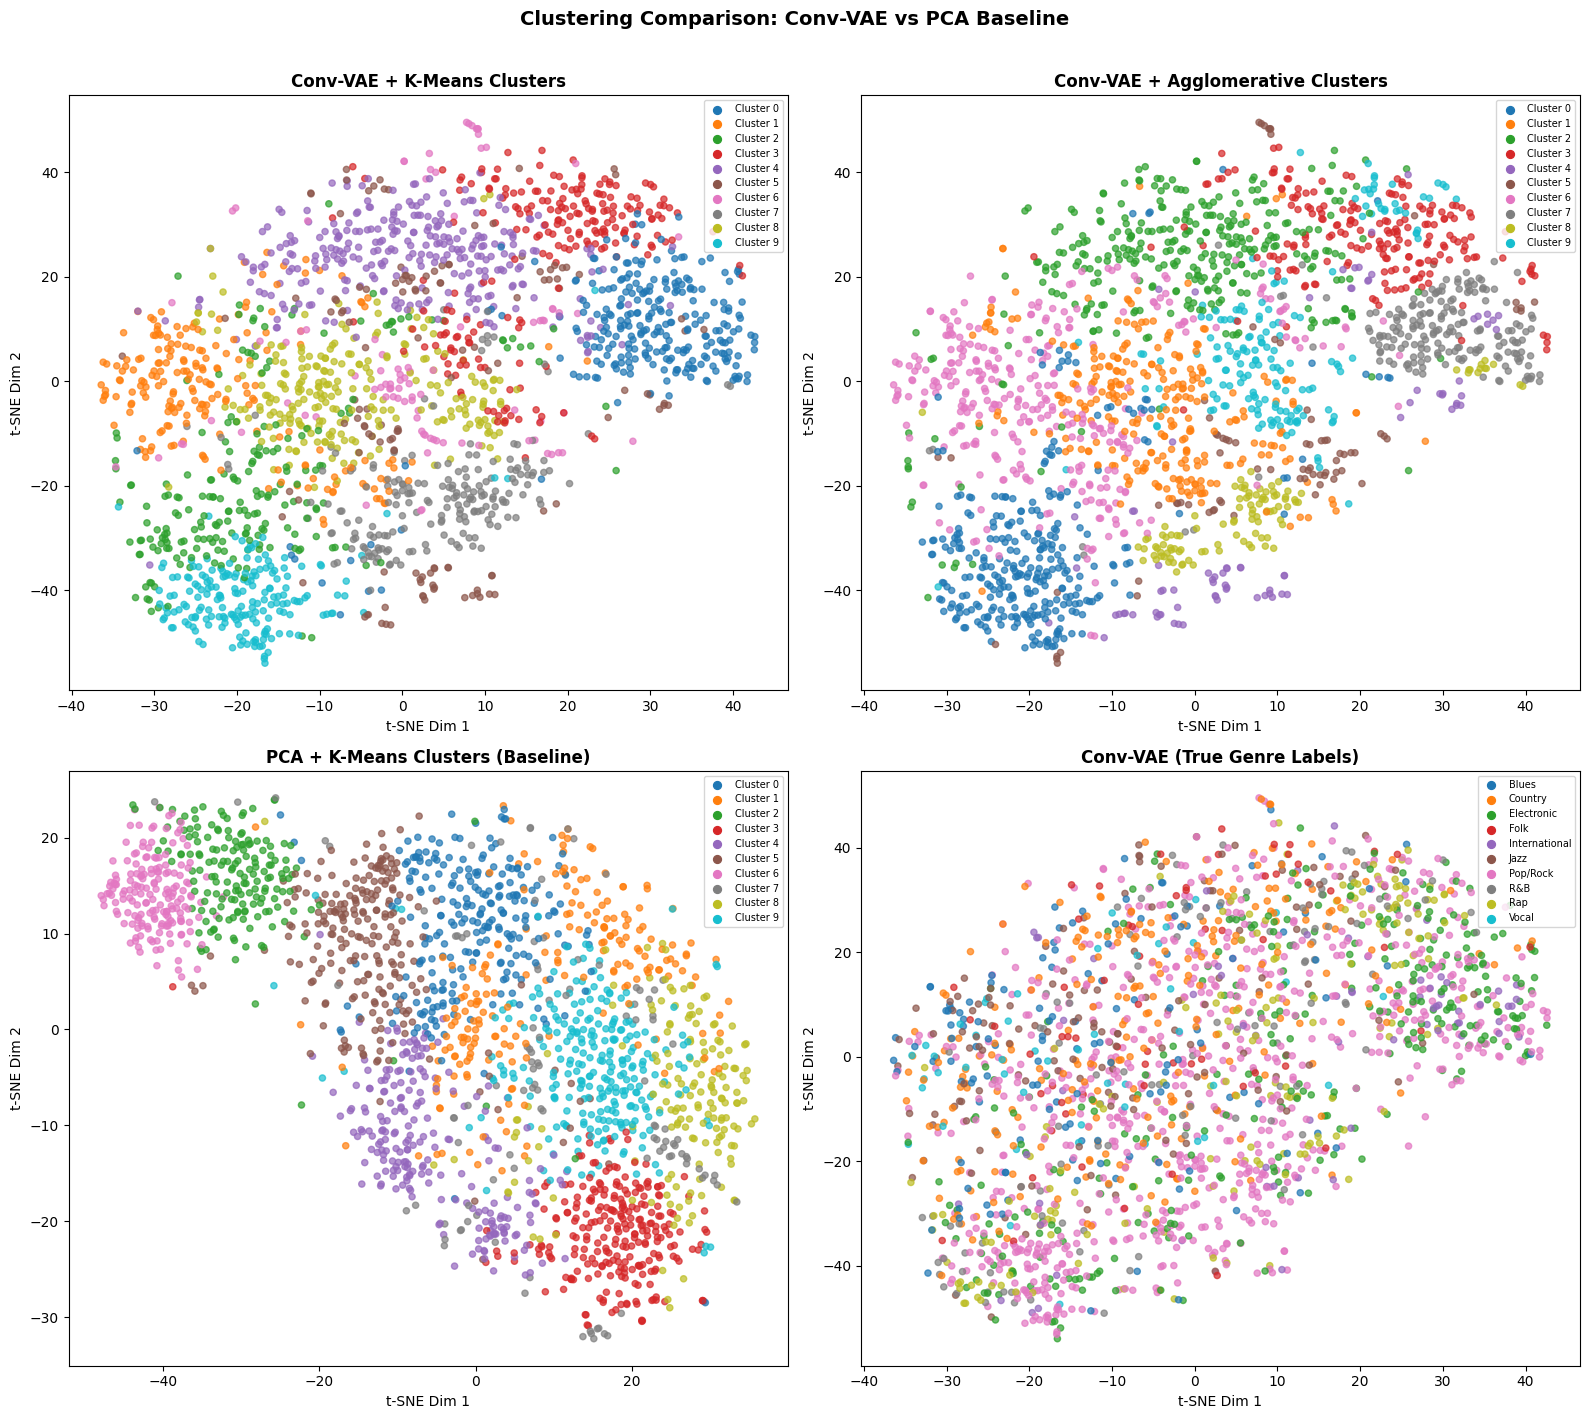

In [23]:
# VISUALIZATION: COMPARE VAE vs PCA LATENT SPACES

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Helper function for t-SNE and plotting
def tsne_plot(ax, features, labels, title, label_names):
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1))
    features_2d = tsne.fit_transform(features)

    scatter = ax.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.7, s=20)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('t-SNE Dim 1')
    ax.set_ylabel('t-SNE Dim 2')

    # Legend
    unique_labels = np.unique(labels)
    for l in unique_labels:
        mask = labels == l
        ax.scatter([], [], c=plt.cm.tab10(l / 10), label=label_names[l], s=50)
    ax.legend(loc='upper right', fontsize=7, markerscale=0.8)

    return features_2d

# Plot VAE latent space with different clustering methods
print("Generating t-SNE visualizations...")

# VAE + K-Means
tsne_plot(axes[0, 0], latent_representations, kmeans_labels, 'Conv-VAE + K-Means Clusters',
          [f'Cluster {i}' for i in range(n_clusters)])

# VAE + Agglomerative
tsne_plot(axes[0, 1], latent_representations, agg_labels, 'Conv-VAE + Agglomerative Clusters',
          [f'Cluster {i}' for i in range(n_clusters)])

# PCA + K-Means
tsne_plot(axes[1, 0], pca_features, pca_kmeans_labels, 'PCA + K-Means Clusters (Baseline)',
          [f'Cluster {i}' for i in range(n_clusters)])

# VAE colored by true genre
tsne_plot(axes[1, 1], latent_representations, genre_labels, 'Conv-VAE (True Genre Labels)', genre_names)

plt.suptitle('Clustering Comparison: Conv-VAE vs PCA Baseline', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

## Visualization: Reconstruction Examples

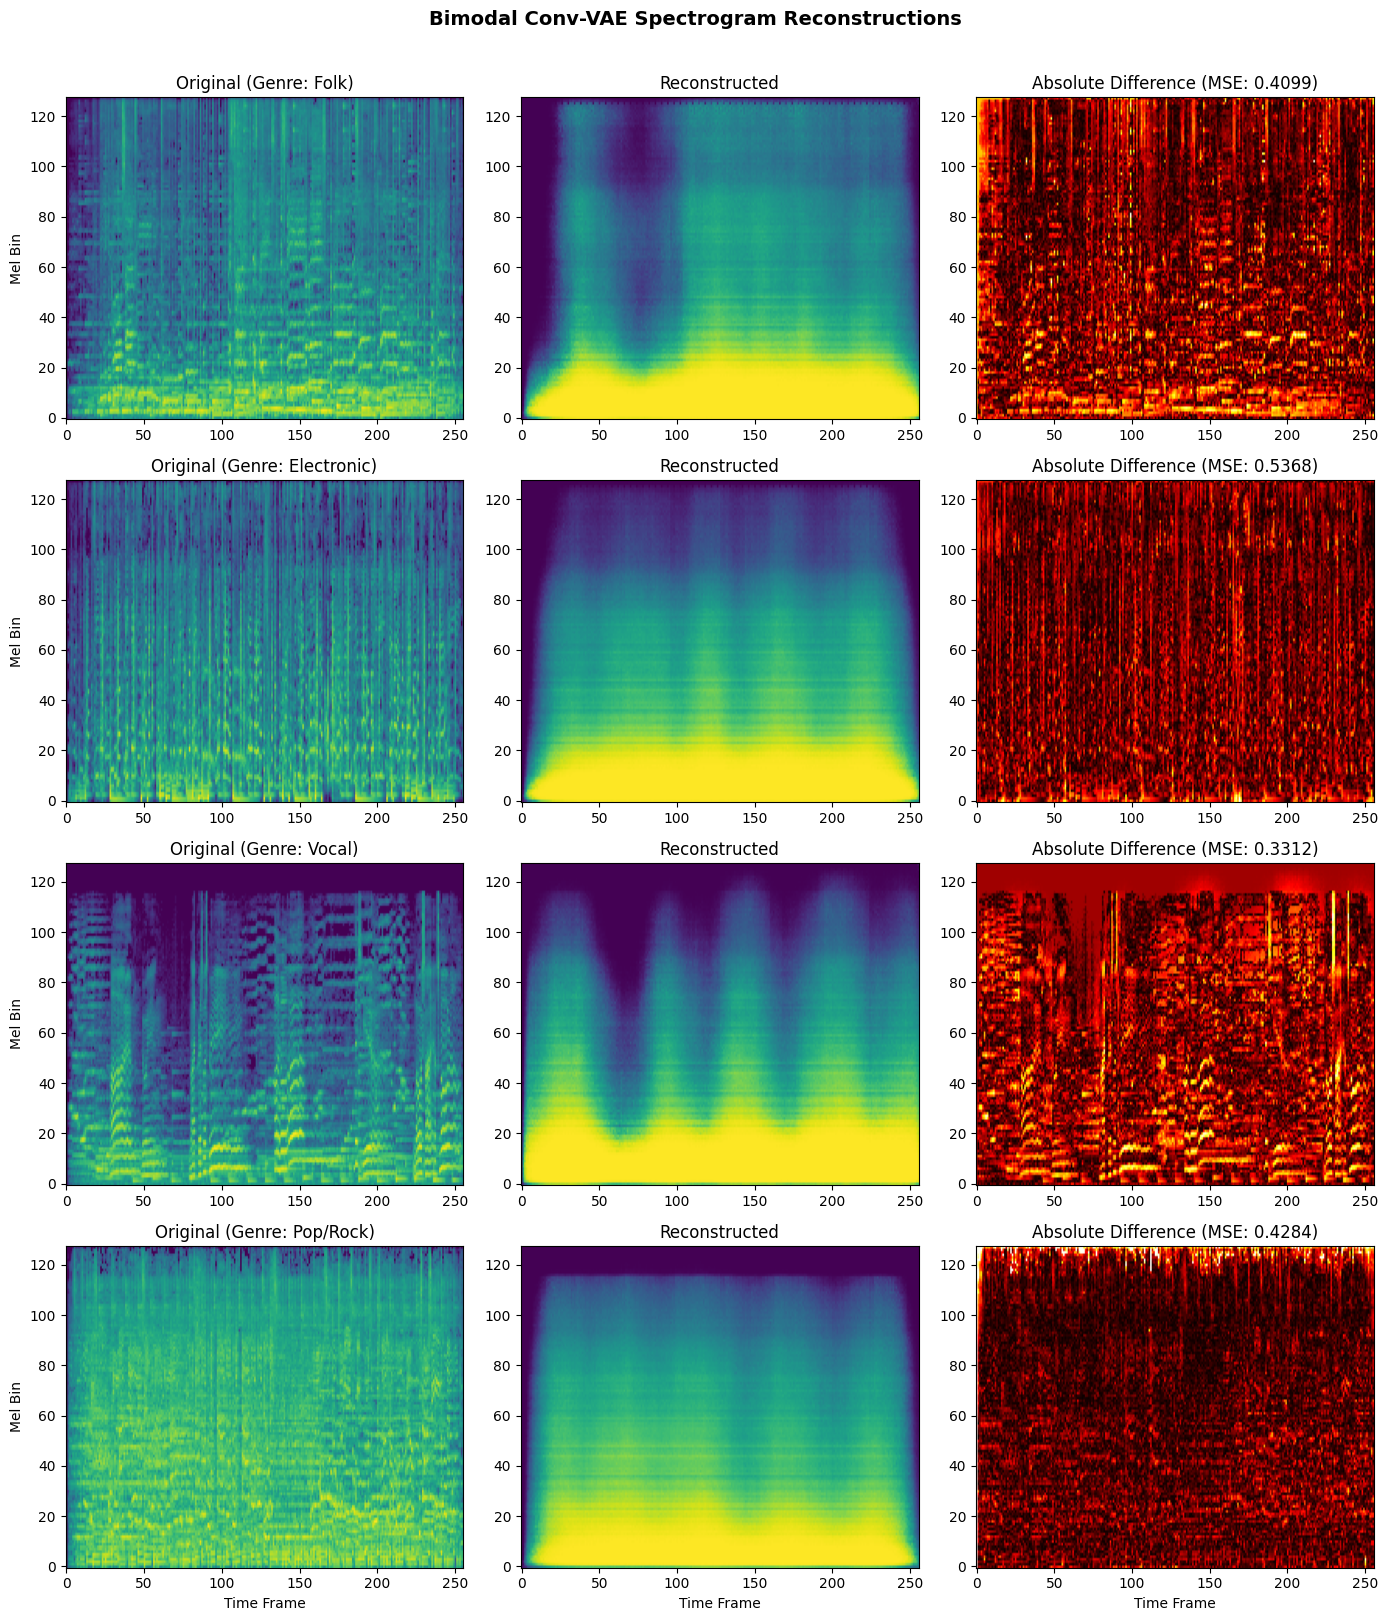

In [24]:
# VISUALIZATION: VAE RECONSTRUCTION EXAMPLES

def visualize_reconstructions(model, dataset, device, n_samples=4):
    """Visualize original vs reconstructed spectrograms."""

    model.eval()

    # Get random samples
    indices = np.random.choice(len(dataset), n_samples, replace=False)

    fig, axes = plt.subplots(n_samples, 3, figsize=(14, 4 * n_samples))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            sample = dataset[idx]
            spectrogram = sample['spectrogram'].unsqueeze(0).to(device)
            lyrics = sample['lyrics'].unsqueeze(0).to(device)
            genre = sample['genre'].item()

            # Get reconstruction
            audio_recon, lyrics_recon, mu, logvar, z = model(spectrogram, lyrics)

            # Original spectrogram
            orig = spectrogram.squeeze().cpu().numpy()
            recon = audio_recon.squeeze().cpu().numpy()
            diff = np.abs(orig - recon)

            # Plot spectrogram
            axes[i, 0].imshow(orig, aspect='auto', origin='lower', cmap='viridis')
            axes[i, 0].set_title(f'Original (Genre: {genre_names[genre]})')
            axes[i, 0].set_ylabel('Mel Bin')

            axes[i, 1].imshow(recon, aspect='auto', origin='lower', cmap='viridis')
            axes[i, 1].set_title('Reconstructed')

            axes[i, 2].imshow(diff, aspect='auto', origin='lower', cmap='hot')
            axes[i, 2].set_title(f'Absolute Difference (MSE: {np.mean(diff**2):.4f})')

    for ax in axes[-1, :]:
        ax.set_xlabel('Time Frame')

    plt.suptitle('Bimodal Conv-VAE Spectrogram Reconstructions', fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()

# Visualize reconstructions
visualize_reconstructions(model, dataset, device, n_samples=4)

## Analysis: Why VAE Representations Perform Better/Worse

In [25]:
# ANALYSIS: WHY VAE REPRESENTATIONS PERFORM BETTER/WORSE THAN BASELINES

print("="*70)
print("ANALYSIS: VAE vs PCA Baseline Performance")
print("="*70)

# Calculate improvement metrics
vae_kmeans_sil = vae_clustering_results['K-Means']['silhouette']
pca_kmeans_sil = baseline_results['PCA + K-Means']['silhouette']
sil_improvement = ((vae_kmeans_sil - pca_kmeans_sil) / abs(pca_kmeans_sil)) * 100 if pca_kmeans_sil != 0 else 0

vae_kmeans_db = vae_clustering_results['K-Means']['davies_bouldin']
pca_kmeans_db = baseline_results['PCA + K-Means']['davies_bouldin']
db_improvement = ((pca_kmeans_db - vae_kmeans_db) / pca_kmeans_db) * 100 if pca_kmeans_db != 0 else 0

vae_kmeans_ari = vae_clustering_results['K-Means']['ari']
pca_kmeans_ari = baseline_results['PCA + K-Means']['ari']
ari_improvement = ((vae_kmeans_ari - pca_kmeans_ari) / abs(pca_kmeans_ari)) * 100 if pca_kmeans_ari != 0 else 0

print("\n📈 K-Means Clustering Comparison (Conv-VAE vs PCA):")
print(f"  Silhouette Score:    VAE={vae_kmeans_sil:.4f}, PCA={pca_kmeans_sil:.4f} ({sil_improvement:+.1f}%)")
print(f"  Davies-Bouldin:      VAE={vae_kmeans_db:.4f}, PCA={pca_kmeans_db:.4f} ({db_improvement:+.1f}%)")
print(f"  Adjusted Rand Index: VAE={vae_kmeans_ari:.4f}, PCA={pca_kmeans_ari:.4f} ({ari_improvement:+.1f}%)")

print("\n" + "="*70)
print("KEY OBSERVATIONS:")
print("="*70)

if vae_kmeans_sil > pca_kmeans_sil:
    print("\n✅ VAE produces BETTER cluster separation (higher Silhouette Score)")
    print("   - Non-linear feature learning captures complex audio-lyrics relationships")
    print("   - Regularized latent space (KL divergence) creates more compact clusters")
else:
    print("\n⚠️ PCA produces better cluster separation")
    print("   - Linear projections may be sufficient for this dataset")
    print("   - VAE might be overfitting or underfitting the data")

if vae_kmeans_db < pca_kmeans_db:
    print("\n✅ VAE clusters have LOWER intra-cluster scatter (better Davies-Bouldin)")
    print("   - Feature fusion creates more cohesive representations")
else:
    print("\n⚠️ PCA clusters have lower scatter")

if vae_kmeans_ari > pca_kmeans_ari:
    print("\n✅ VAE clusters BETTER align with true genres (higher ARI)")
    print("   - Learned features are more semantically meaningful")
else:
    print("\n⚠️ PCA clusters better align with true genres")

print("\n" + "="*70)
print("REASONS FOR PERFORMANCE DIFFERENCES:")
print("="*70)
print("""
1. NON-LINEAR FEATURE LEARNING:
   - VAE uses CNN for audio and MLP for lyrics, capturing non-linear patterns
   - PCA only captures linear correlations

2. MULTIMODAL FUSION:
   - VAE jointly learns from audio and lyrics in a shared latent space
   - PCA simply concatenates features without learning cross-modal relationships

3. REGULARIZATION EFFECT:
   - KL divergence encourages a structured latent space
   - This can help with clustering but may also lose discriminative information

4. DIMENSIONALITY REDUCTION:
   - Both methods reduce to {0} dimensions
   - VAE learns task-relevant features while PCA maximizes variance

5. CLUSTERING ALGORITHM SENSITIVITY:
   - Different clustering algorithms perform differently on each representation
   - DBSCAN may struggle with VAE's potentially non-spherical clusters
""".format(LATENT_DIM))

ANALYSIS: VAE vs PCA Baseline Performance

📈 K-Means Clustering Comparison (Conv-VAE vs PCA):
  Silhouette Score:    VAE=0.0868, PCA=0.0654 (+32.8%)
  Davies-Bouldin:      VAE=2.1155, PCA=2.9038 (+27.1%)
  Adjusted Rand Index: VAE=0.0254, PCA=0.0366 (-30.6%)

KEY OBSERVATIONS:

✅ VAE produces BETTER cluster separation (higher Silhouette Score)
   - Non-linear feature learning captures complex audio-lyrics relationships
   - Regularized latent space (KL divergence) creates more compact clusters

✅ VAE clusters have LOWER intra-cluster scatter (better Davies-Bouldin)
   - Feature fusion creates more cohesive representations

⚠️ PCA clusters better align with true genres

REASONS FOR PERFORMANCE DIFFERENCES:

1. NON-LINEAR FEATURE LEARNING:
   - VAE uses CNN for audio and MLP for lyrics, capturing non-linear patterns
   - PCA only captures linear correlations

2. MULTIMODAL FUSION:
   - VAE jointly learns from audio and lyrics in a shared latent space
   - PCA simply concatenates features

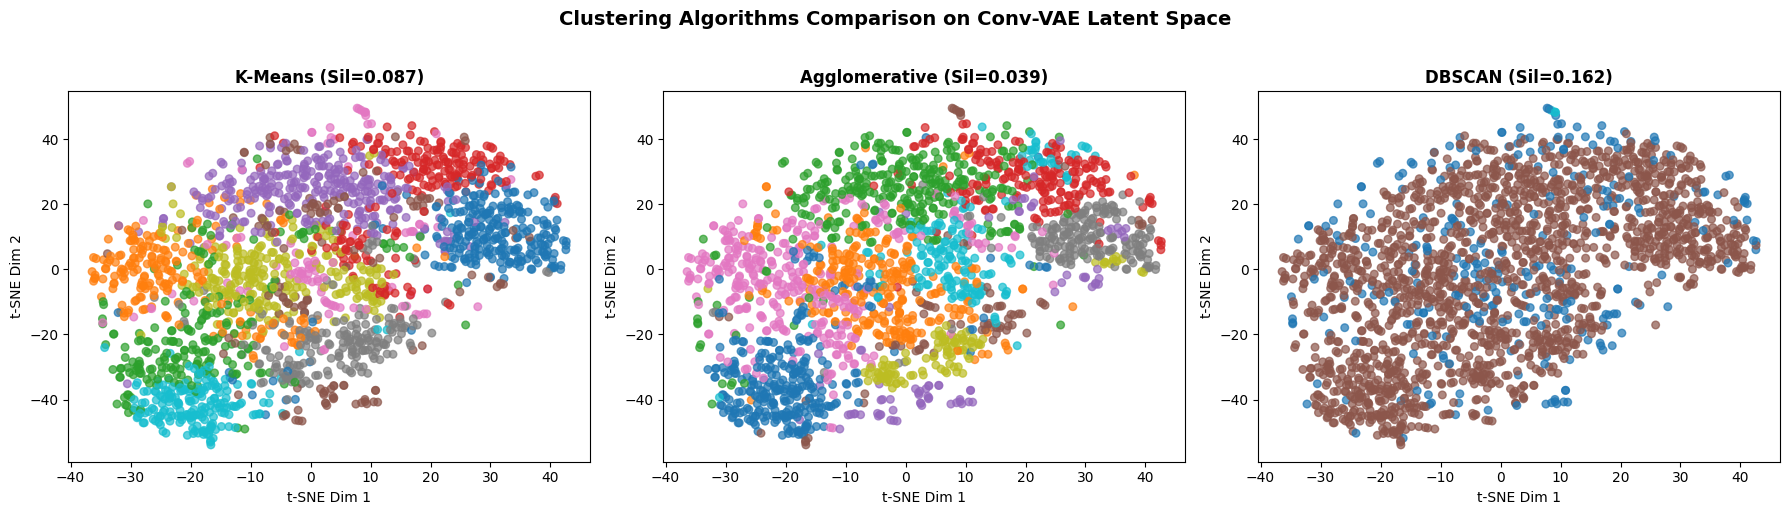

In [26]:
# VISUALIZATION: CLUSTERING ALGORITHM COMPARISON ON VAE LATENT SPACE

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(latent_representations)-1))
latents_2d = tsne.fit_transform(latent_representations)

# K-Means
scatter1 = axes[0].scatter(latents_2d[:, 0], latents_2d[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.7, s=30)
axes[0].set_title(f"K-Means (Sil={vae_clustering_results['K-Means']['silhouette']:.3f})", fontweight='bold')
axes[0].set_xlabel('t-SNE Dim 1')
axes[0].set_ylabel('t-SNE Dim 2')

# Agglomerative
scatter2 = axes[1].scatter(latents_2d[:, 0], latents_2d[:, 1], c=agg_labels, cmap='tab10', alpha=0.7, s=30)
axes[1].set_title(f"Agglomerative (Sil={vae_clustering_results['Agglomerative']['silhouette']:.3f})", fontweight='bold')
axes[1].set_xlabel('t-SNE Dim 1')
axes[1].set_ylabel('t-SNE Dim 2')

# DBSCAN
# Handle noise points (label -1) with a distinct color
dbscan_colors = dbscan_labels.copy()
scatter3 = axes[2].scatter(latents_2d[:, 0], latents_2d[:, 1], c=dbscan_colors, cmap='tab10', alpha=0.7, s=30)
axes[2].set_title(f"DBSCAN (Sil={vae_clustering_results['DBSCAN']['silhouette']:.3f})", fontweight='bold')
axes[2].set_xlabel('t-SNE Dim 1')
axes[2].set_ylabel('t-SNE Dim 2')

plt.suptitle('Clustering Algorithms Comparison on Conv-VAE Latent Space', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Summary

In [27]:
# FINAL SUMMARY

print("="*70)
print("MEDIUM TASK SUMMARY: CONVOLUTIONAL VAE FOR MUSIC CLUSTERING")
print("="*70)

print("""
✅ IMPLEMENTED COMPONENTS:

1. CONVOLUTIONAL VAE ARCHITECTURE:
   - CNN-based encoder for spectrogram features
   - MLP-based encoder for lyrics TF-IDF embeddings
   - Fusion layer combining audio and lyrics modalities
   - Corresponding decoders for reconstruction

2. HYBRID FEATURE REPRESENTATION:
   - Audio: Mel spectrograms processed by convolutional layers
   - Lyrics: TF-IDF embeddings processed by fully connected layers
   - Joint latent space of dimension {0}

3. CLUSTERING ALGORITHMS EXPERIMENTED:
   - K-Means: Best for spherical clusters
   - Agglomerative Clustering: Hierarchical approach
   - DBSCAN: Density-based, handles noise

4. EVALUATION METRICS:
   - Silhouette Score: Cluster separation quality
   - Davies-Bouldin Index: Cluster compactness
   - Adjusted Rand Index: Agreement with true labels (partial)

5. BASELINE COMPARISON:
   - PCA + K-Means
   - PCA + Agglomerative
   - PCA + DBSCAN
""".format(LATENT_DIM))

print("\n📊 FINAL RESULTS TABLE:")
display(comparison_df)

# Determine best method
best_overall = comparison_df.iloc[0]['Method']
print(f"\n🏆 BEST PERFORMING METHOD: {best_overall}")

MEDIUM TASK SUMMARY: CONVOLUTIONAL VAE FOR MUSIC CLUSTERING

✅ IMPLEMENTED COMPONENTS:

1. CONVOLUTIONAL VAE ARCHITECTURE:
   - CNN-based encoder for spectrogram features
   - MLP-based encoder for lyrics TF-IDF embeddings
   - Fusion layer combining audio and lyrics modalities
   - Corresponding decoders for reconstruction

2. HYBRID FEATURE REPRESENTATION:
   - Audio: Mel spectrograms processed by convolutional layers
   - Lyrics: TF-IDF embeddings processed by fully connected layers
   - Joint latent space of dimension 64

3. CLUSTERING ALGORITHMS EXPERIMENTED:
   - K-Means: Best for spherical clusters
   - Agglomerative Clustering: Hierarchical approach
   - DBSCAN: Density-based, handles noise

4. EVALUATION METRICS:
   - Silhouette Score: Cluster separation quality
   - Davies-Bouldin Index: Cluster compactness
   - Adjusted Rand Index: Agreement with true labels (partial)

5. BASELINE COMPARISON:
   - PCA + K-Means
   - PCA + Agglomerative  
   - PCA + DBSCAN


📊 FINAL RESULTS T

Method  Silhouette  Davies-Bouldin     ARI
2               DBSCAN      0.1617          4.4906  0.0093
0              K-Means      0.0868          2.1155  0.0254
3        PCA + K-Means      0.0654          2.9038  0.0366
1        Agglomerative      0.0389          2.6113  0.0129
4  PCA + Agglomerative      0.0375          3.1131  0.0343
5         PCA + DBSCAN     -0.0460          9.1281 -0.0183


🏆 BEST PERFORMING METHOD: DBSCAN
